# Libraries installation and data downloading

In [1]:
!pip install tqdm
!pip install pillow --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.0.1
    Uninstalling Pillow-9.0.1:
      Successfully uninstalled Pillow-9.0.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

Matplotlib is building the font cache; this may take a moment.


In [3]:
urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

In [4]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [5]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


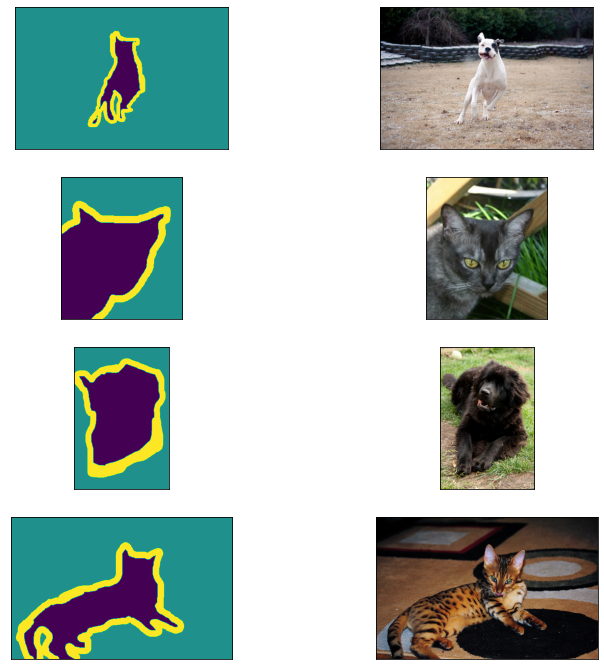

In [8]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

# S3 bucket and data uploading

In [11]:
bucket_name = 'segmentation-bucket-tutorial'
training_image = get_image_uri(boto3.Session().region_name, 'semantic-segmentation',
                              repo_version='latest')
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


991648021394.dkr.ecr.ap-south-1.amazonaws.com/semantic-segmentation:1


In [12]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

In [13]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:04<00:00, 1637.45it/s]


In [14]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [15]:
print(len(train_annots), len(train_images))

5595 5595


In [16]:
sess = sagemaker.Session()

print('Starting upload..')
s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print('Training images uploaded')
s3_train_annotation_path = sess.upload_data(path='train_annotation', bucket=bucket_name,
                                     key_prefix='train_annotation')
print('Training Annotations uploaded')
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name,
                                      key_prefix='validation')
print('Validation images uploaded')
s3_validation_annotation_path = sess.upload_data(path='validation_annotation', bucket=bucket_name,
                                          key_prefix='validation_annotation')
print('Validation Annotations uploaded')

Starting upload..
Training images uploaded
Training Annotations uploaded
Validation images uploaded
Validation Annotations uploaded


# Model training

In [24]:
role = sagemaker.get_execution_role()

model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size=100,
    max_run=36000,
    input_mode='File',
    output_path='s3://semantic-imagespets/output',
    sagemaker_session=sess
)

In [25]:
model.set_hyperparameters(
    backbone='resnet-50', # This is the encoder. Other option is resnet-50
    algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
    use_pretrained_model='True', # Use the pre-trained model.
    crop_size=240, # Size of image random crop.                             
    num_classes=4, # Pascal has 21 classes. This is a mandatory parameter.
    epochs=10, # Number of epochs to run.
    learning_rate=0.0001,                             
    optimizer='rmsprop', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
    mini_batch_size=16, # Setup some mini batch size.
    validation_mini_batch_size=16,
    early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=3, # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10, # No matter what, run these many number of epochs.                             
    num_training_samples=len(train_images)
)

In [26]:
train_data = sagemaker.inputs.TrainingInput(s3_train_path, distribution='FullyReplicated',
                          content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.inputs.TrainingInput(s3_validation_path, distribution='FullyReplicated',
                          content_type='image/jpeg', s3_data_type='S3Prefix')

train_annotation_data = sagemaker.inputs.TrainingInput(s3_train_annotation_path, distribution='FullyReplicated',
                          content_type='image/png', s3_data_type='S3Prefix')
validation_annotation_data = sagemaker.inputs.TrainingInput(s3_validation_annotation_path, distribution='FullyReplicated',
                          content_type='image/png', s3_data_type='S3Prefix')

In [27]:
data_channels = {
    'train': train_data,
    'train_annotation': train_annotation_data,
    'validation': validation_data,
    'validation_annotation': validation_annotation_data
}

In [28]:
model.fit(inputs=data_channels, logs=True)

ClientError: An error occurred (ValidationException) when calling the CreateTrainingJob operation: Instance type ml.m4.xlarge is not supported by algorithm semantic-segmentation; only GPU instances are supported.

# Model deployment and testing

In [ ]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed!')

In [ ]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

In [ ]:
index = 2

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b, initial_args={"ContentType": "image/jpeg", "Accept": "image/png"})

In [ ]:
import io

mask = np.array(Image.open(io.BytesIO(results)))

In [ ]:
plt.imshow(plt.imread(image_path))

In [ ]:
plt.imshow(mask)